In [3]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 15 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 3
cfg['set_id'] = 4

In [4]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [5]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [6]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [7]:
from dataloader import *
from models import *
import time

model = GRU_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [8]:
model.train()

GRU_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (gru): GRU(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 0.86998
count = 4, loss = 0.50205
count = 6, loss = 0.51035
count = 8, loss = 0.32023
count = 10, loss = 0.29436
count = 12, loss = 0.33267
count = 14, loss = 0.36775
validation loss: 0.2864433601498604
epoch finished: 1
count = 2, loss = 0.31472
count = 4, loss = 0.28715
count = 6, loss = 0.30938
count = 8, loss = 0.28794
count = 10, loss = 0.26688
count = 12, loss = 0.30751
count = 14, loss = 0.27363
validation loss: 0.31224295496940613
epoch finished: 2
count = 2, loss = 0.28139
count = 4, loss = 0.24769
count = 6, loss = 0.27357
count = 8, loss = 0.25062
count = 10, loss = 0.23834
count = 12, loss = 0.39022
count = 14, loss = 0.24850
validation loss: 0.3747740685939789
epoch finished: 3
count = 2, loss = 0.27536
count = 4, loss = 0.27212
count = 6, loss = 0.22630
count = 8, loss = 0.29531
count = 10, loss = 0.26628
count = 12, loss = 0.22596
count = 14, loss = 0.26350
validation loss: 0.3440469652414322
epoch finished: 4
count = 2, loss = 0.29754
count = 4, loss =

In [18]:
np.save('val_loss_gru_set4.npy', val_losses)
np.save('train_loss_gru_set4.npy', train_losses)

In [21]:
model = load_model(LSTM_Score, './models/s4_ba120e9b14.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [10]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.419575572013855
validation MAE: 0.17525764554738998
QWK Score: 0.7076948700866089


In [11]:
targets

[array([1, 1, 1, 2, 2, 2, 3, 1, 2, 1, 3, 1, 0, 2, 1, 2, 2, 1, 3, 1, 3, 0,
        2, 1, 1, 1, 2, 3, 0, 1, 2, 1, 1, 2, 2, 3, 1, 3, 2, 2, 2, 2, 2, 0,
        2, 0, 0, 3, 2, 3, 0, 1, 2, 1, 0, 0, 2, 0, 1, 1, 2, 2, 0, 3, 2, 2,
        2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1, 0, 2, 1, 2, 2, 2, 1, 3,
        2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 3, 1, 3, 1, 2, 1, 2, 1, 1, 2, 0,
        2, 1, 1, 1, 2, 3, 2, 2, 0, 0]),
 array([3, 2, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, 3, 1, 2, 3, 1, 3, 2, 2, 2, 1,
        1, 1, 1, 2, 1, 0, 1, 3, 1, 1, 1, 2, 3, 2, 1, 1, 3, 1, 2, 0, 3, 2,
        1, 1, 2, 2, 1, 2, 2, 2, 0, 3, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2,
        1, 2, 3, 1, 1, 2, 1, 1, 1, 2, 3, 2, 1, 1, 1, 2, 0, 1, 2, 0, 1, 0,
        3, 3, 1, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, 3, 0, 1, 1, 1, 2, 2, 2, 1,
        3, 1, 2, 3, 2, 2, 2, 3, 2, 3]),
 array([1, 2, 1, 0, 2, 0, 2, 3, 1, 2, 2, 2, 1, 3, 3, 1, 1, 2, 1, 3, 2, 0,
        1, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 2, 1, 2, 1,
        2, 0, 1, 3, 1, 1, 1, 2, 

In [12]:
preds

[array([0, 1, 1, 1, 2, 3, 2, 1, 2, 0, 3, 1, 0, 3, 1, 2, 2, 1, 2, 0, 3, 0,
        1, 0, 1, 1, 2, 3, 0, 1, 2, 0, 1, 2, 2, 3, 1, 3, 3, 1, 1, 0, 1, 0,
        3, 1, 0, 3, 2, 2, 0, 0, 3, 1, 1, 0, 2, 1, 1, 1, 3, 3, 0, 3, 3, 1,
        2, 2, 3, 3, 1, 2, 1, 2, 2, 1, 1, 3, 3, 1, 0, 1, 1, 2, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 3, 2, 1, 1, 0, 2, 3, 2, 3, 1, 2, 1, 2, 1, 1, 2, 0,
        1, 0, 1, 1, 2, 2, 2, 2, 0, 1]),
 array([2, 1, 2, 1, 3, 0, 0, 1, 2, 2, 1, 1, 2, 1, 2, 3, 1, 3, 1, 2, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 3, 2, 1, 1, 0, 3, 0, 3, 0, 3, 1,
        1, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2,
        0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 3, 3, 0, 1, 1, 3, 0, 1, 1, 1, 1, 0,
        3, 3, 1, 3, 2, 1, 3, 1, 1, 2, 3, 2, 1, 3, 0, 0, 1, 2, 2, 1, 0, 1,
        3, 0, 1, 3, 2, 1, 3, 2, 2, 3]),
 array([1, 1, 1, 0, 2, 0, 3, 3, 0, 3, 2, 3, 1, 2, 3, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 3, 0, 1, 1, 1, 1, 0, 2, 1, 3, 1,
        1, 1, 1, 3, 2, 0, 1, 1, 

In [13]:
train_losses

[0.8699824959039688,
 0.5020499974489212,
 0.510354533791542,
 0.3202286809682846,
 0.2943574786186218,
 0.3326726257801056,
 0.36774660646915436,
 0.31472449004650116,
 0.2871462553739548,
 0.30938321352005005,
 0.28794100880622864,
 0.2668822556734085,
 0.30751243978738785,
 0.27363115549087524,
 0.2813863083720207,
 0.24768735468387604,
 0.2735731154680252,
 0.25062239170074463,
 0.23833566159009933,
 0.3902166336774826,
 0.24849580228328705,
 0.2753599286079407,
 0.27212443947792053,
 0.22629795223474503,
 0.295308381319046,
 0.26627522706985474,
 0.2259572297334671,
 0.26349572092294693,
 0.2975388765335083,
 0.2240193411707878,
 0.23932061344385147,
 0.23490037769079208,
 0.26777975261211395,
 0.2687610313296318,
 0.2868047505617142,
 0.31726688891649246,
 0.2666366994380951,
 0.2523640841245651,
 0.2613182067871094,
 0.23310887813568115,
 0.2437974289059639,
 0.2345740795135498,
 0.22288573533296585,
 0.3473067432641983,
 0.18849217146635056,
 0.2695761173963547,
 0.257262088358

In [14]:
val_losses

[0.2864433601498604,
 0.31224295496940613,
 0.3747740685939789,
 0.3440469652414322,
 0.4450392872095108,
 0.3719106465578079,
 0.4194048270583153,
 0.3535832241177559,
 0.3645319566130638,
 0.3811189904808998,
 0.3283419534564018,
 0.3855357691645622,
 0.3785258010029793,
 0.3876785710453987,
 0.4053519070148468]

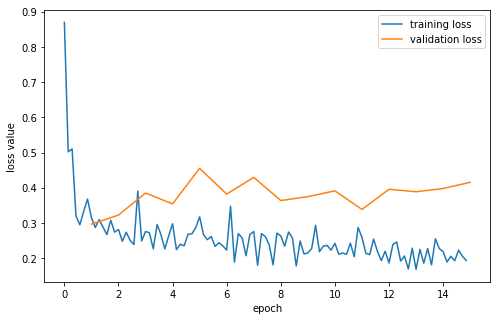

In [16]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()